In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

%config IPCompleter.greedy=True
%matplotlib inline

In [58]:
train = pd.read_csv('train_sample.csv')

In [36]:
def preprocessing(data):
    print(data.columns)
    if data.columns.contains('attributed_time'):
        data = data.drop(['attributed_time'], axis=1)
    data['day'] = pd.DatetimeIndex(data['click_time']).day
    data['hour'] = pd.DatetimeIndex(data['click_time']).hour
    data['minute'] = pd.DatetimeIndex(data['click_time']).minute
    data['sec'] = pd.DatetimeIndex(data['click_time']).second
    data = data.drop(['click_time'], axis=1)
    return data

In [6]:
train.head()

,ip,app,device,os,channel,is_attributed,day,hour,minute,sec
0,87540,12,1,13,497,0,7,9,30,38
1,105560,25,1,17,259,0,7,13,40,27
2,101424,12,1,19,212,0,7,18,5,24
3,94584,13,1,13,477,0,7,4,58,8
4,68413,12,1,1,178,0,9,9,0,9


In [10]:
train_data = train[['ip', 'app', 'device', 'os', 'channel', 'day', 'hour', 'minute', 'sec']]
X_train, X_test, y_train, y_test = train_test_split(train_data, train['is_attributed'])

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [45]:
X_train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'day', 'hour', 'minute', 'sec'], dtype='object')

In [13]:
params = {'eta': 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}

In [14]:
watchlist = [(dtrain, 'train'), (dtest, 'valid')]
model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)


[0]	train-auc:0.827046	valid-auc:0.849556
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[5]	train-auc:0.952432	valid-auc:0.938595
[10]	train-auc:0.968535	valid-auc:0.953043
[15]	train-auc:0.999473	valid-auc:0.961856
[20]	train-auc:0.999936	valid-auc:0.955514
[25]	train-auc:0.999983	valid-auc:0.965939
[30]	train-auc:0.999991	valid-auc:0.966017
[35]	train-auc:0.999993	valid-auc:0.958971
[40]	train-auc:0.999996	valid-auc:0.9646
[45]	train-auc:0.999998	valid-auc:0.964591
Stopping. Best iteration:
[22]	train-auc:0.999952	valid-auc:0.970656



In [47]:
preds = model.predict(dtest)

In [48]:
roc_auc = roc_auc_score(y_test, preds)
print("ROC AUC: %f" % (roc_auc))

ROC AUC: 0.963538


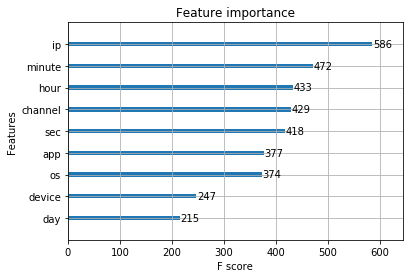

In [49]:
xgb.plot_importance(model)


In [33]:
test = pd.read_csv('test.csv', nrows=100000)
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [22]:
test.size

131533283

In [59]:
click_ids = test.drop(['click_id'], axis=1)
test = test.drop(['click_id'], axis=1)


In [60]:
dval = xgb.DMatrix(preprocessing(test))

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'day', 'hour',
       'minute', 'sec'],
      dtype='object')


In [61]:
preds_test = model.predict(dval)

In [62]:
preds_test

array([0.0038515 , 0.00200174, 0.00064859, ..., 0.00019769, 0.0001379 ,
       0.00048165], dtype=float32)